# ***화승***

## ***IMPORT LIBRARY***
---

In [13]:
### Library Import 
import os
import re
import sys
import glob
import shap
import optuna
import pickle
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import xgboost as xgb
from tqdm import tqdm
from scipy import stats
import statsmodels.api as sm
from functools import partial
from pandarallel import pandarallel
from xgboost import XGBRegressor, callback as xgb_callback
from datetime import timedelta, time, datetime
from scipy.stats import truncnorm
from IPython.display import Image
from optbinning import OptimalBinning
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.patches as patches
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
warnings.filterwarnings('ignore')
plt.rc('font', family='Apple SD Gothic Neo')

# Pandas 옵션 설정 
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

# Scikit-Learn 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence 

# Import fns 
from utils import * 
from hwaseung_fn import * 

## ***Load Dataset***
---

In [2]:
### Cluster Dict 
cluster_dict = {
        'cluster1': {'products': ["FFWED70284","FFWED70007","FFWED70267","FFWED70103","FFWED70199","FFSED70438","FFWED70033",
                                "FFWES60194","FFSED70498","FFSED70533","FFWED70321"],
                    'var': 'T5'},
        'cluster2': {'products': ["FFWED70019","FFWED70102","FFWED70283","FFHED70076","FFWED70338",
                                "FFHED70014","FFSED70032","FFHED70147",
                                "FFHED60009","FFHED60006"],
                    'var': 'T3'},
        'cluster3': {'products': ["HCSED50105", "HCSED60072",
                                "HCWED60031", "HCSED50391", "HCSED70092", "HCSED60024",],
                    'var': 'M/B 점도 (ML)'},
        'cluster4': {'products': ["HCSED60010", "HCSES60015", "HCWES60017",
                                "HCSED70584", "HCSED60530", "HCSED50047",
                                "HCSED40011", "HCSED20006",
                                "HCWED70019", "FCHED60002", "FCWED70009",
                                "HCSED60017", "HCSED70143"],
                    'var': 'M/B 점도 (MS)'}
        }

# Random Seed & Path 
random_seed = 22
path = '/Users/hwijongim/Library/CloudStorage/OneDrive-앰버로드/문서 - Solution/2502_화승/20.수행/22.분석과제/250408_분석_sm'

# Product 정의 
train_cluster = "cluster1"
p_codes = cluster_dict['cluster1']['products']  

# Target 
target_list = ["Ct 90"] + ["Scorch (T5)", "Scorch (T3)"] + ['Vm (T5)', "Vm (T3)", "M/B 점도 (ML)", "M/B 점도 (MS)"] + ["경도"]

# Data Import 
        # Log 
log_df = pd.read_csv(f"{path}/log_df_10s.csv")
log_df = log_df[log_df["제품코드"].isin(cluster_dict[train_cluster]["products"])] 
        # QA 
qa_df = pd.read_csv(f"{path}/qa_df.csv") 
        # Recipe
recipe_df = pd.read_csv(f"{path}/recipe_df.csv") 
        # INFO 
info = pd.read_excel(f"{path}/투입자재 CODE별 비중 정보.xlsx", header=1, index_col=0).reset_index(drop=True)
        # Weather 
weather_df = pd.read_csv(f"{path}/weather_dg.csv")
weather_df["연월일"] = weather_df["연월일"].astype(str)

# Print 
print('='*100)
print(f'Log Dataset: {log_df.shape}')
print(f'QA Dataset: {qa_df.shape}')
print(f'Recipe Dataset: {recipe_df.shape}')
print(f'INFO Dataset: {info.shape}')
print(f'Weather Dataset: {weather_df.shape}')
print('='*100)

Log Dataset: (2389691, 37)
QA Dataset: (334291, 16)
Recipe Dataset: (1813072, 13)
INFO Dataset: (80, 2)
Weather Dataset: (1268, 5)


## ***Data Preprocessing***
---

In [3]:
### Log Dataset 정제 
log_df4, log_df5 = prep_log(log_df)

# Print 
print('='*100)
print(f'Log Dataset: {log_df4.shape}')
print(f'Log Train Dataset: {log_df5.shape}')
print('='*100)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Log Dataset: (2176948, 39)
Log Train Dataset: (33311, 18)


In [4]:
### QA Dataset 정제 
qa_df4, qa_df5 = prep_qa(qa_df, p_codes, target_list)

# Print 
print('='*100)
print(f'Qa Dataset: {qa_df4.shape}')
print(f'Qa Train Dataset: {qa_df5.shape}')
print('='*100)

Qa Dataset: (95239, 4)
Qa Train Dataset: (44297, 9)


In [5]:
### Recipe Dataset 정제 
recipe_df = prep_recipe(recipe_df, info) 

# Print 
print('='*100)
print(f'Recipe Dataset: {recipe_df.shape}')
print('='*100)

Recipe Dataset: (123200, 2)


In [6]:
### Concat Dataset 
df1 = pd.merge(left=log_df5, right=qa_df5, on="작업지시번호-배치", how="left")
df2 = pd.merge(left=df1, right=recipe_df, on="작업지시번호-배치", how="left")
df3 = pd.merge(left=df2, right=weather_df, on="연월일", how="left").drop(["연월일"], axis=1)    

# Print 
print('='*100)
print(f'Daset Shape: {df3.shape}')
print('='*100)


Daset Shape: (33311, 30)


In [20]:
### Cluster label 생성 
clst = {1: ['FFWED70267', 'FFWED70033'],
        2: ['FFWED70007', 'FFWED70103'],
        3: ['FFSED70498', 'FFWED70321'],
        4: ['FFSED70438', 'FFSED70533'],
        5: ['FFWES60194'],
        6: ['FFWED70284', 'FFWED70199']}

# 1) 제품코드 추출
df3["제품코드_extracted"] = df3["작업지시번호-배치"].str[6:16]

# 2) 매핑 dict 생성
code_to_cluster = {c: k for k, codes in clst.items() for c in codes}

# 3) 매핑 적용 
df3["cluster"] = df3.get("cluster", pd.Series(index=df3.index))
df3["cluster"] = df3["cluster"].fillna(df3["제품코드_extracted"].map(code_to_cluster))
df3["cluster"] = df3["cluster"].astype("Int64")

df3 = df3.drop(columns=["제품코드_extracted"])
# dataset = df3.drop(columns=['cluster']).reset_index(drop=True).copy()  
dataset = df3.copy()

# Print 
print('='*100)
print(f'Train Dataset Shape: {dataset.shape}')
print('='*100)

Train Dataset Shape: (33311, 31)


In [16]:
### Target Value 확인 
# 확인할 컬럼 리스트
target_lst = ['cycle time','Ct 90_결과','Scorch (T5)_결과','Vm (T5)_결과','경도_결과']

print('='*100)
print(dataset[target_lst].count())
print('='*100)

cycle time        33190
Ct 90_결과          22146
Scorch (T5)_결과    14417
Vm (T5)_결과        14417
경도_결과             18175
dtype: int64


## ***MODELLING***
---

In [30]:
### Train Test Split 
# Targets 
targets = ['cycle time','Ct 90_결과','Scorch (T5)_결과','Vm (T5)_결과','경도_결과']

# Cycle Time 
cycle_train_dataset, cycle_test_dataset = create_train_test_dataset(dataset, targets[0]) 

# CT90 
ct_train_dataset, ct_test_dataset = create_train_test_dataset(dataset, targets[1]) 

# Scorch 
sc_train_dataset, sc_test_dataset = create_train_test_dataset(dataset, targets[2]) 

# Vm 
vm_train_dataset, vm_test_dataset = create_train_test_dataset(dataset, targets[3]) 

# Hard 
hard_train_dataset, hard_test_dataset = create_train_test_dataset(dataset, targets[4]) 

# Print 
print('='*100)
print(f"{'cycle time':<21} | {len(cycle_train_dataset):>14,} | {len(cycle_test_dataset):>13,}")
print(f"{'Ct 90_결과':<20} | {len(ct_train_dataset):>14,} | {len(ct_test_dataset):>13,}")
print(f"{'Scorch (T5)_결과':<20} | {len(sc_train_dataset):>14,} | {len(sc_test_dataset):>13,}")
print(f"{'Vm (T5)_결과':<20} | {len(vm_train_dataset):>14,} | {len(vm_test_dataset):>13,}")
print(f"{'경도_결과':<19} | {len(hard_train_dataset):>14,} | {len(hard_test_dataset):>13,}") 
print("="*100)

cycle time            |         21,588 |         5,064
Ct 90_결과             |         13,541 |         3,177
Scorch (T5)_결과       |          9,329 |         2,189
Vm (T5)_결과           |          9,329 |         2,189
경도_결과               |         12,888 |         3,024


[I 2025-10-21 15:16:17,784] A new study created in memory with name: no-name-87b4210c-f1c7-469b-a531-bab1c9485581


학습할 Tree Features: 20 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'cluster']
학습 Tree 데이터 수: 21588


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-21 15:16:23,699] Trial 0 finished with value: 4.199426392929483 and parameters: {'n_estimators': 2480, 'max_depth': 9, 'learning_rate': 0.050155495259636265, 'subsample': 0.7510996030143828, 'gamma': 0.21959369883229918, 'reg_lambda': 0.26464913980530197}. Best is trial 0 with value: 4.199426392929483.
[I 2025-10-21 15:16:38,261] Trial 1 finished with value: 5.008227204963528 and parameters: {'n_estimators': 2671, 'max_depth': 7, 'learning_rate': 0.0011159475976353585, 'subsample': 0.9551784437625235, 'gamma': 0.31298192928040336, 'reg_lambda': 2.5457838171108826}. Best is trial 0 with value: 4.199426392929483.
[I 2025-10-21 15:16:44,979] Trial 2 finished with value: 4.284815322106876 and parameters: {'n_estimators': 857, 'max_depth': 9, 'learning_rate': 0.009183882490496066, 'subsample': 0.9928880320261502, 'gamma': 0.47154043659022254, 'reg_lambda': 0.016751211048127785}. Best is trial 0 with value: 4.199426392929483.
[I 2025-10-21 15:16:50,095] Trial 3 finished with value

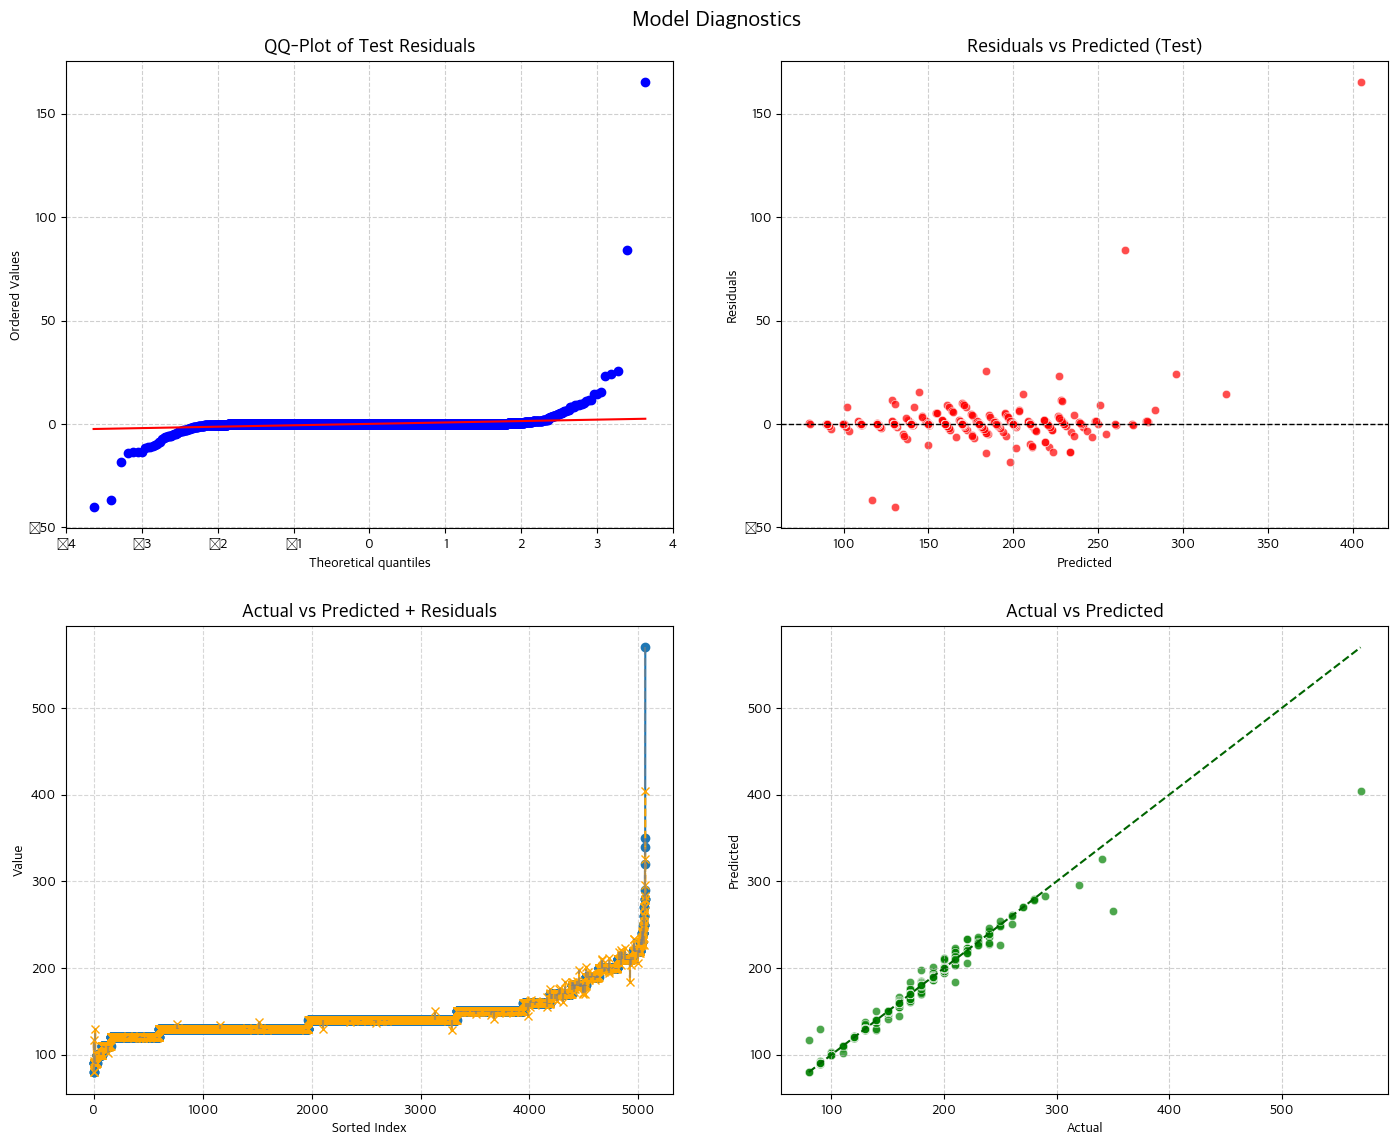

[I 2025-10-21 15:17:51,798] A new study created in memory with name: no-name-12417798-20a5-4ad9-9044-1279a3c012b1


Train Accuracy
Train RMSE : 0.068
Train R2   : 1.000
Train SMAPE : 0.01
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 2.959
Test R2   : 0.988
Test SMAPE : 0.12
학습할 Tree Features: 20 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'cluster']
학습 Tree 데이터 수: 13541
Sample Weight std=3, margin=89.69, ratio=33.048%
Sample Weight STD 채택 완료: ratio=33.05% (std=3)


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-21 15:18:00,571] Trial 0 finished with value: 8.591937064358794 and parameters: {'n_estimators': 2156, 'max_depth': 6, 'learning_rate': 0.016505174364687493, 'subsample': 0.717513399132643, 'gamma': 0.31470303196719673, 'reg_lambda': 0.1830732212824887}. Best is trial 0 with value: 8.591937064358794.
[I 2025-10-21 15:18:07,597] Trial 1 finished with value: 8.614295496337284 and parameters: {'n_estimators': 1671, 'max_depth': 7, 'learning_rate': 0.06291182668391133, 'subsample': 0.8860767029506568, 'gamma': 0.3917760259538252, 'reg_lambda': 0.005012140846756674}. Best is trial 0 with value: 8.591937064358794.
[I 2025-10-21 15:18:14,658] Trial 2 finished with value: 8.873416422502686 and parameters: {'n_estimators': 667, 'max_depth': 10, 'learning_rate': 0.005115972359309072, 'subsample': 0.7315545296373922, 'gamma': 0.07546544736915839, 'reg_lambda': 0.17261908097151538}. Best is trial 0 with value: 8.591937064358794.
[I 2025-10-21 15:18:26,252] Trial 3 finished with value: 8

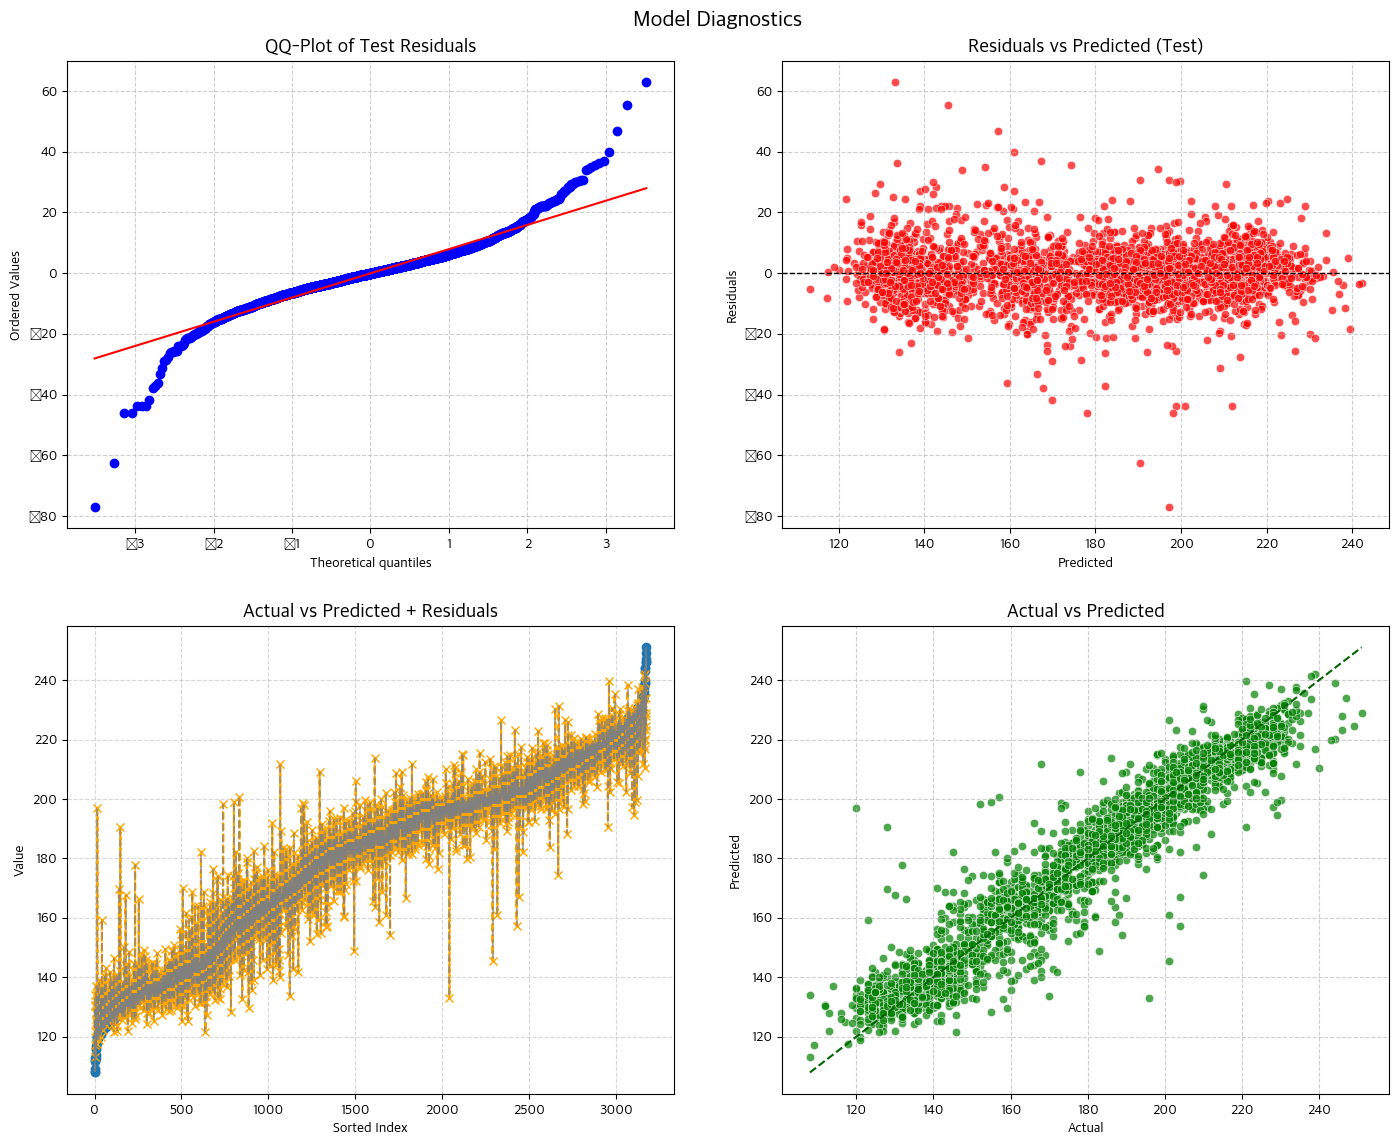

[I 2025-10-21 15:19:06,132] A new study created in memory with name: no-name-7a164c1f-e1df-431e-b4a8-bbfd70b78ebb


Train Accuracy
Train RMSE : 1.628
Train R2   : 0.997
Train SMAPE : 0.72
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 8.299
Test R2   : 0.924
Test SMAPE : 3.33
학습할 Tree Features: 20 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'cluster']
학습 Tree 데이터 수: 9329
Sample Weight std=3, margin=207.64, ratio=25.405%
Sample Weight STD 채택 완료: ratio=25.40% (std=3)


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-21 15:19:20,357] Trial 0 finished with value: 23.248736092615236 and parameters: {'n_estimators': 2654, 'max_depth': 10, 'learning_rate': 0.020163925820225397, 'subsample': 0.988110127212626, 'gamma': 0.22077191265400253, 'reg_lambda': 0.0028134189172467306}. Best is trial 0 with value: 23.248736092615236.
[I 2025-10-21 15:19:22,599] Trial 1 finished with value: 29.37007343622876 and parameters: {'n_estimators': 561, 'max_depth': 6, 'learning_rate': 0.0031923389731133944, 'subsample': 0.7153726318238615, 'gamma': 0.295296554708887, 'reg_lambda': 0.0012499924538177218}. Best is trial 0 with value: 23.248736092615236.
[I 2025-10-21 15:19:39,692] Trial 2 finished with value: 22.67496975396014 and parameters: {'n_estimators': 2884, 'max_depth': 8, 'learning_rate': 0.009999115467208596, 'subsample': 0.875607611561185, 'gamma': 0.43493822956485173, 'reg_lambda': 0.014333799823684334}. Best is trial 2 with value: 22.67496975396014.
[I 2025-10-21 15:19:54,678] Trial 3 finished with 

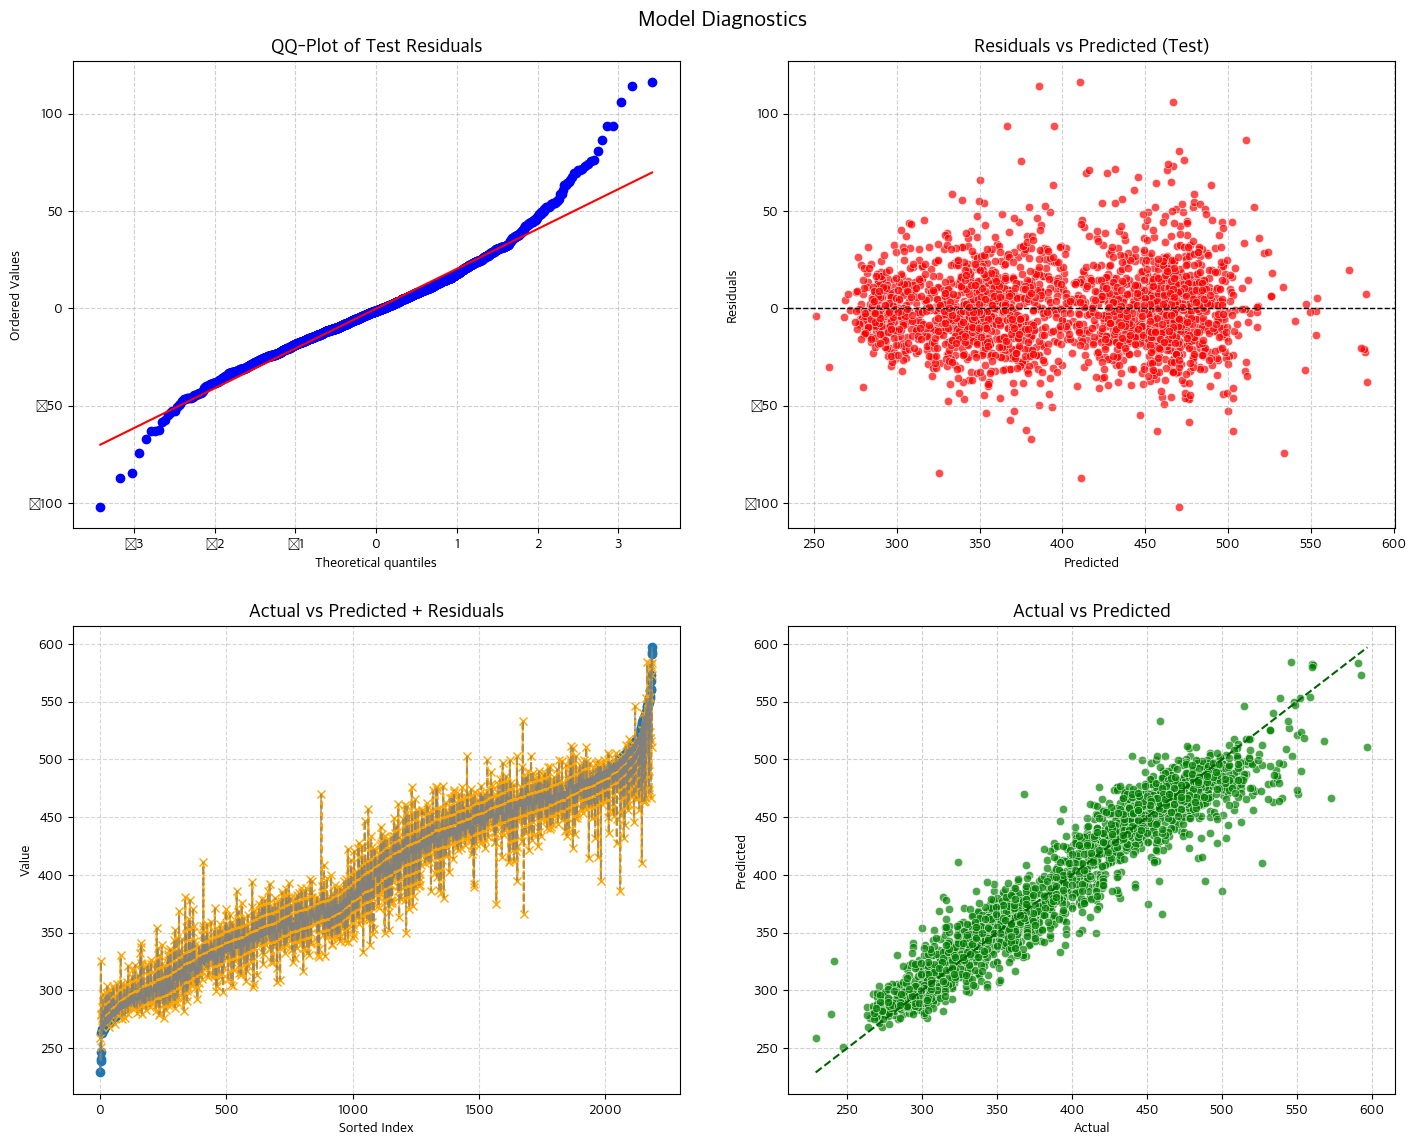

[I 2025-10-21 15:20:44,262] A new study created in memory with name: no-name-27618022-71eb-4d43-a070-f182b2c9c9c4


Train Accuracy
Train RMSE : 4.237
Train R2   : 0.996
Train SMAPE : 0.83
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 20.757
Test R2   : 0.915
Test SMAPE : 3.93
학습할 Tree Features: 20 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'cluster']
학습 Tree 데이터 수: 9329
Sample Weight std=3, margin=10.28, ratio=25.265%
Sample Weight STD 채택 완료: ratio=25.27% (std=3)


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-21 15:20:51,595] Trial 0 finished with value: 1.3945281521264938 and parameters: {'n_estimators': 2346, 'max_depth': 6, 'learning_rate': 0.02723074781726799, 'subsample': 0.8251921070458379, 'gamma': 0.2798626993371265, 'reg_lambda': 0.3266140119947369}. Best is trial 0 with value: 1.3945281521264938.
[I 2025-10-21 15:20:59,398] Trial 1 finished with value: 1.400131978412195 and parameters: {'n_estimators': 1664, 'max_depth': 7, 'learning_rate': 0.02886299862569812, 'subsample': 0.7072494705913344, 'gamma': 0.036476160866303065, 'reg_lambda': 0.041927199800235605}. Best is trial 0 with value: 1.3945281521264938.
[I 2025-10-21 15:21:03,284] Trial 2 finished with value: 1.4926771986518943 and parameters: {'n_estimators': 2698, 'max_depth': 12, 'learning_rate': 0.1525178274028792, 'subsample': 0.9142270224577849, 'gamma': 0.3338850381205326, 'reg_lambda': 0.33604632798094375}. Best is trial 0 with value: 1.3945281521264938.
[I 2025-10-21 15:21:10,082] Trial 3 finished with valu

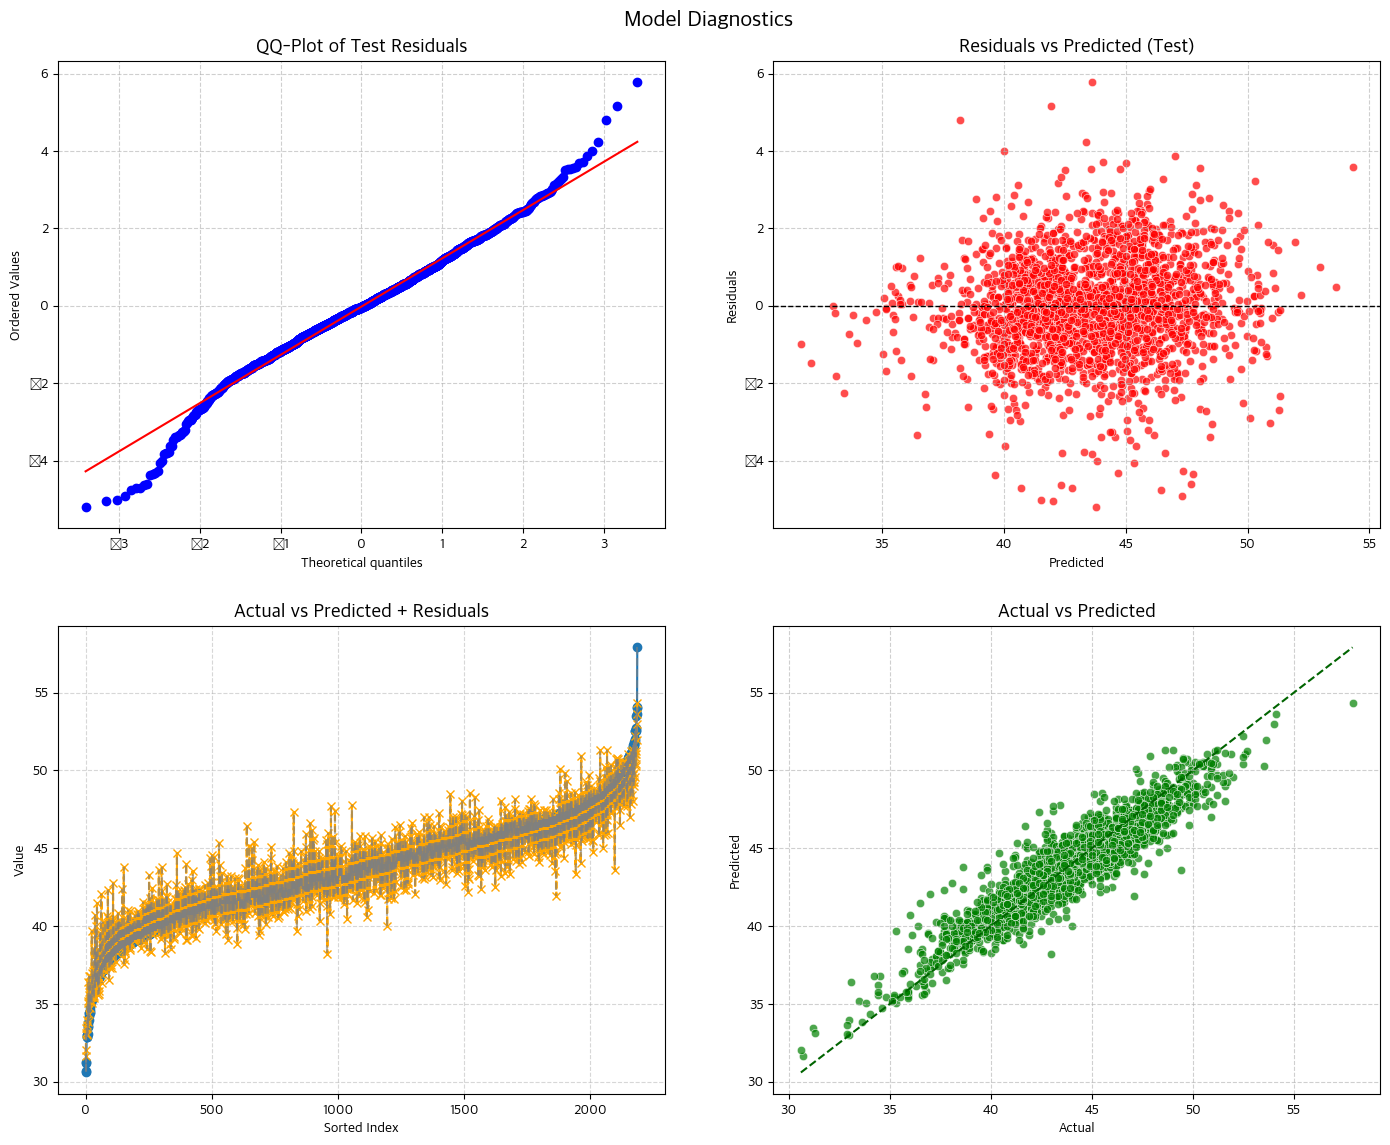

[I 2025-10-21 15:22:04,262] A new study created in memory with name: no-name-c95a9045-8814-4c9f-ac4f-8b4ce001bda1


Train Accuracy
Train RMSE : 0.440
Train R2   : 0.984
Train SMAPE : 0.75
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 1.252
Test R2   : 0.866
Test SMAPE : 2.19
학습할 Tree Features: 20 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN', 'cluster']
학습 Tree 데이터 수: 12888
Sample Weight std=3, margin=7.69, ratio=8.892%
Sample Weight std=5, margin=12.81, ratio=8.892%
Sample Weight std=7, margin=17.94, ratio=8.892%


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-21 15:22:06,673] Trial 0 finished with value: 1.7177396943763572 and parameters: {'n_estimators': 381, 'max_depth': 8, 'learning_rate': 0.0016952327887617663, 'subsample': 0.836131596320564, 'gamma': 0.302361597964462, 'reg_lambda': 2.0478880507111783}. Best is trial 0 with value: 1.7177396943763572.
[I 2025-10-21 15:22:17,931] Trial 1 finished with value: 1.0813273209513778 and parameters: {'n_estimators': 1901, 'max_depth': 8, 'learning_rate': 0.01399271247522786, 'subsample': 0.9407667196383087, 'gamma': 0.052893061874587366, 'reg_lambda': 0.0018980452860492183}. Best is trial 1 with value: 1.0813273209513778.
[I 2025-10-21 15:22:30,505] Trial 2 finished with value: 1.0795955339764245 and parameters: {'n_estimators': 2966, 'max_depth': 7, 'learning_rate': 0.011070607874567867, 'subsample': 0.7328312160767302, 'gamma': 0.4740802527112326, 'reg_lambda': 0.14195699009523735}. Best is trial 2 with value: 1.0795955339764245.
[I 2025-10-21 15:22:34,921] Trial 3 finished with va

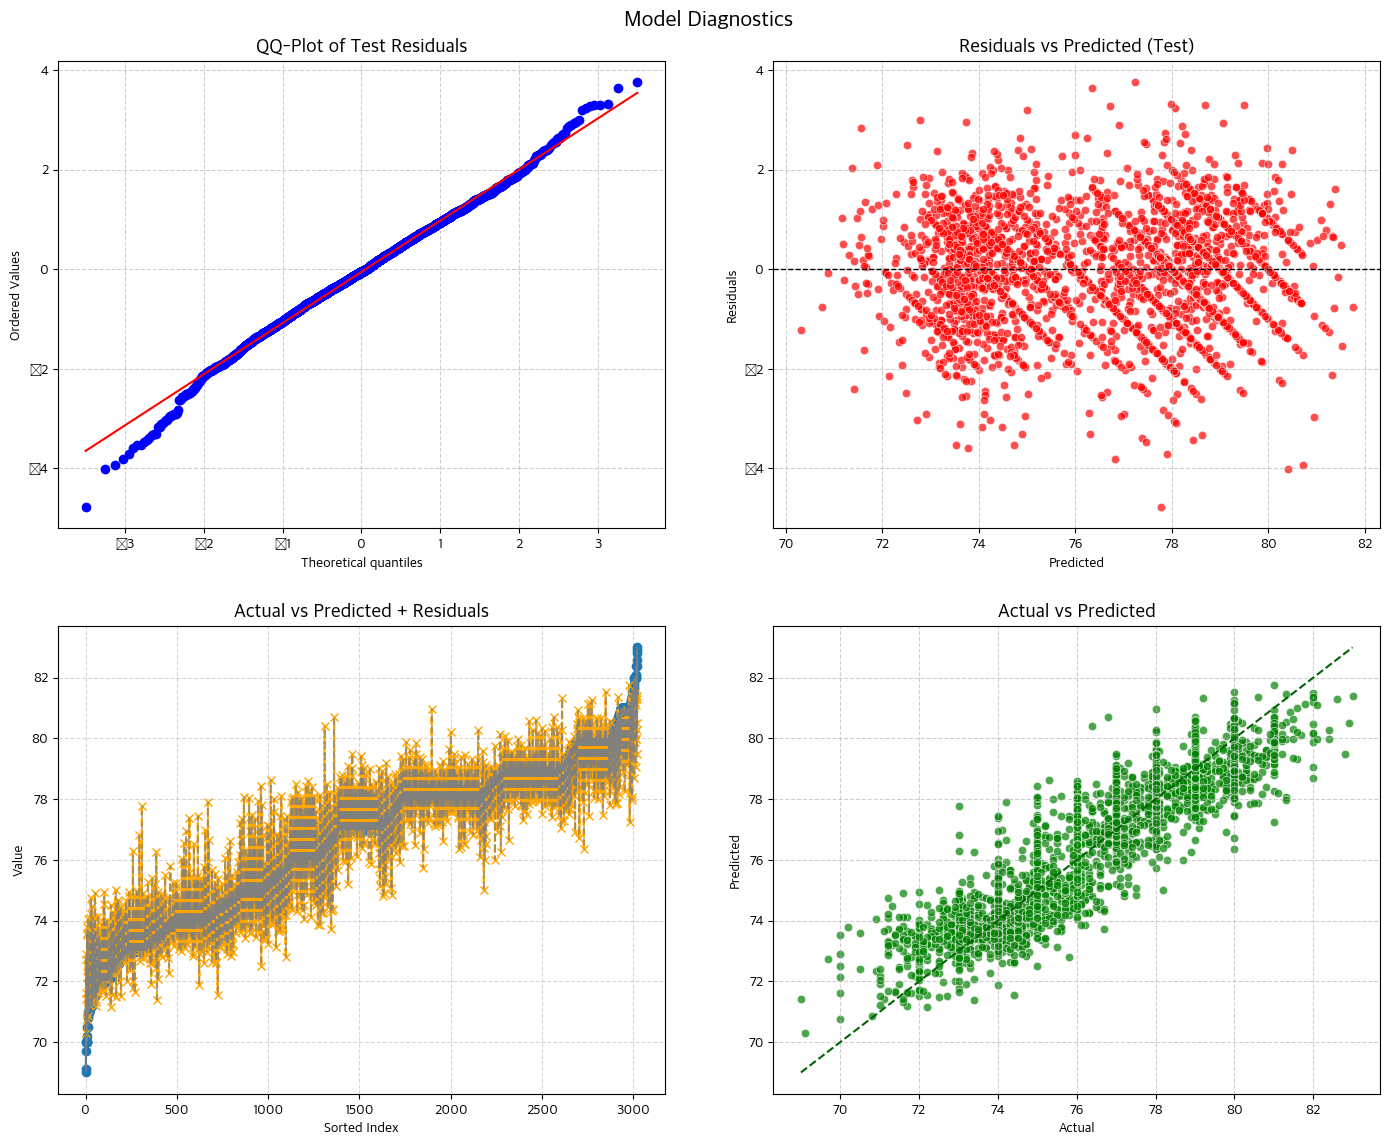

Train Accuracy
Train RMSE : 0.466
Train R2   : 0.967
Train SMAPE : 0.48
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 1.029
Test R2   : 0.835
Test SMAPE : 1.05


In [46]:
### Modelling 
# Cycle Time 
cycle_model, cycle_importance = train_tree(cycle_train_dataset, cycle_test_dataset, target_col='cycle time')

# CT90 
ct_model, ct_importance = train_tree_sample_weight(ct_train_dataset, ct_test_dataset, target_col='Ct 90_결과', cluster_cond=1, target_criterion=210, sample_weight=1.5)

# Scorch 
sc_model, sc_importance = train_tree_sample_weight(sc_train_dataset, sc_test_dataset, target_col='Scorch (T5)_결과', cluster_cond=1, target_criterion=450, sample_weight=1.5)

# Vm 
vm_model, vm_importance = train_tree_sample_weight(vm_train_dataset, vm_test_dataset, target_col='Vm (T5)_결과', cluster_cond=1, target_criterion=42, sample_weight=1.5)

# Hard 
hard_model, hard_importance = train_tree_sample_weight(hard_train_dataset, hard_test_dataset, target_col='경도_결과', cluster_cond=1, target_criterion=75, sample_weight=1.5)

In [ ]:
### Feature Importance 
print('='*100)
print('Cycle Time')
print(cycle_importance)
print('-'*100)
print('CT90')
print(ct_importance)
print('-'*100)
print('Scorch')
print(sc_importance)
print('-'*100)
print('점도')
print(vm_importance)
print('-'*100)
print('경도')
print(hard_importance)
print('='*100)

Cycle Time
----------------------------------------------------------------------------------------------------
CT90
              Feature  Importance  rank
0             cluster    0.336851     1
1          step1_time    0.274640     2
2   step2_Rotor speed    0.245603     3
3                 필팩터    0.072861     4
4   step1_Rotor speed    0.015198     5
5              TA_MIN    0.010229     6
6              TA_AVG    0.007799     7
7           step1_전력량    0.006287     8
8              TA_MAX    0.005484     9
9           step3_전력량    0.003758    10
10       step3_Ram 압력    0.002634    11
11         step2_time    0.002432    12
12  step3_Rotor speed    0.002411    13
13         step3_time    0.002383    14
14        step3_mix온도    0.002219    15
15       step2_Ram 압력    0.002030    16
16          step2_전력량    0.002003    17
17       step1_Ram 압력    0.001838    18
18        step2_mix온도    0.001703    19
19        step1_mix온도    0.001638    20
-------------------------------------------

[I 2025-10-20 12:59:51,046] A new study created in memory with name: no-name-a6845ecf-aa60-4871-811e-8d7475b19c20


학습할 Tree Features: 8 | ['step1_Ram 압력', 'step1_Rotor speed', 'step1_mix온도', 'step1_전력량', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN']
학습 Tree 데이터 수: 25982


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-20 12:59:54,660] Trial 0 finished with value: 3.096175593430379 and parameters: {'n_estimators': 1667, 'max_depth': 12, 'learning_rate': 0.15829601882090083, 'subsample': 0.7103608796306412, 'gamma': 0.4754580566359373, 'reg_lambda': 0.48706103197331685}. Best is trial 0 with value: 3.096175593430379.
[I 2025-10-20 12:59:59,911] Trial 1 finished with value: 4.835739123225981 and parameters: {'n_estimators': 956, 'max_depth': 7, 'learning_rate': 0.001620750230357612, 'subsample': 0.8822160767928536, 'gamma': 0.43522791525974136, 'reg_lambda': 0.093267805965718}. Best is trial 0 with value: 3.096175593430379.
[I 2025-10-20 13:00:11,388] Trial 2 finished with value: 2.9840890973908074 and parameters: {'n_estimators': 1810, 'max_depth': 8, 'learning_rate': 0.007289580234773648, 'subsample': 0.7632186334080149, 'gamma': 0.42622372069380104, 'reg_lambda': 0.001182727911922336}. Best is trial 2 with value: 2.9840890973908074.
[I 2025-10-20 13:00:16,510] Trial 3 finished with value:

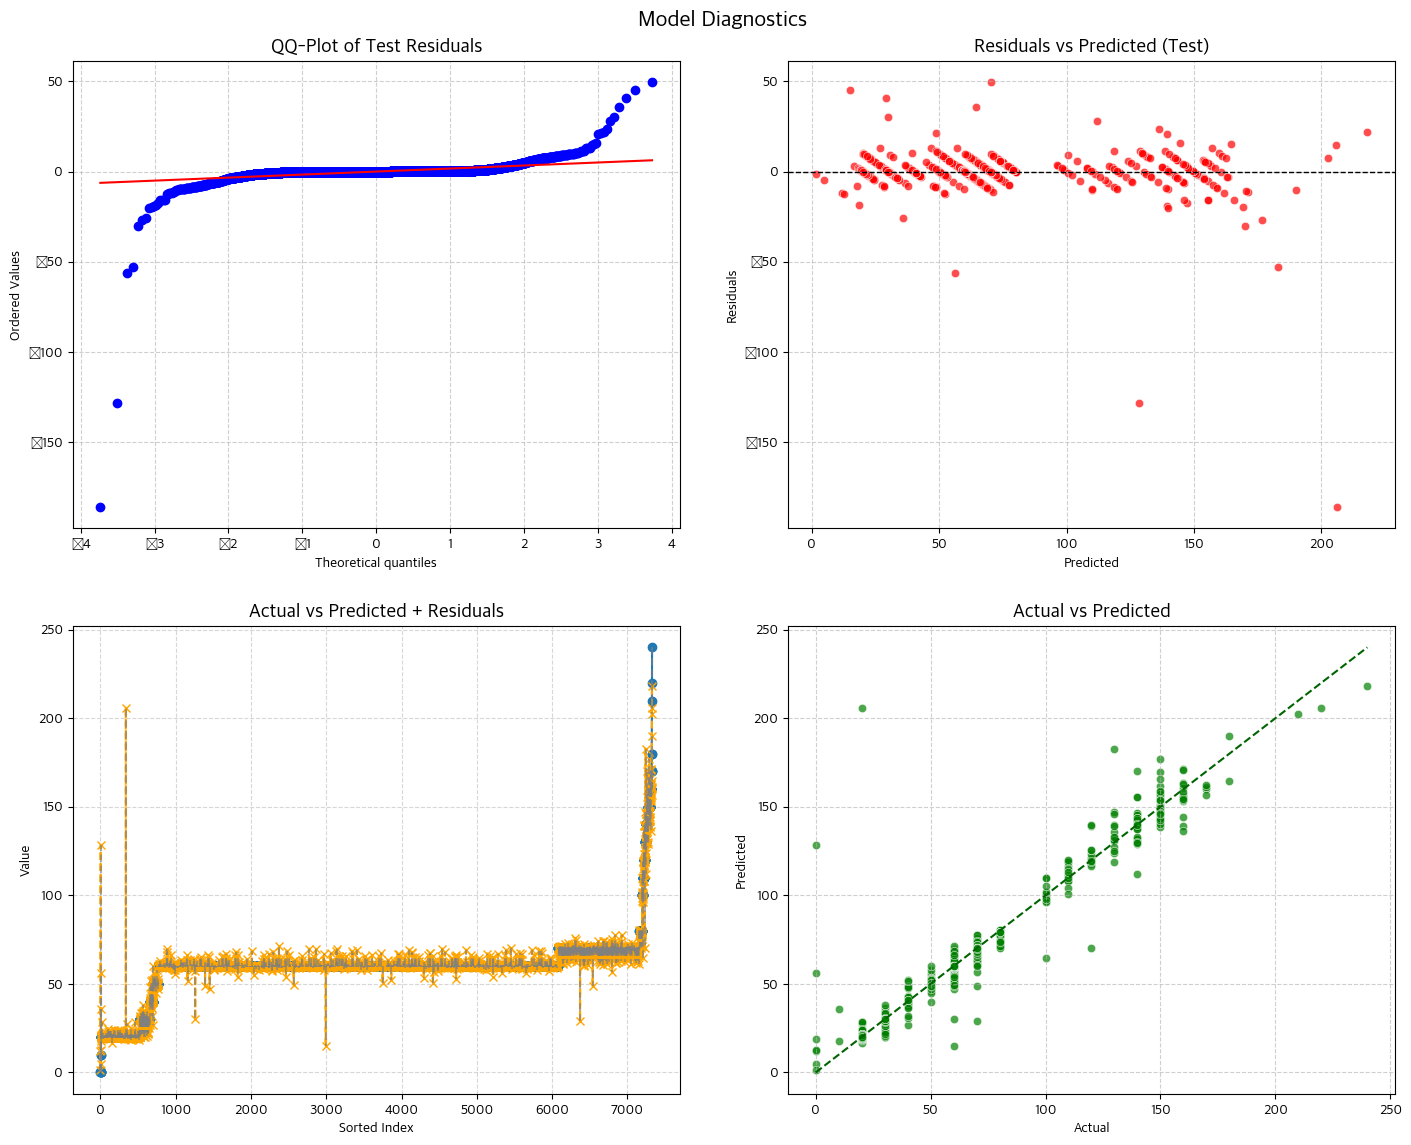

Train Accuracy
Train RMSE : 0.850
Train R2   : 0.997
Train SMAPE : 0.75
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 3.603
Test R2   : 0.953
Test SMAPE : 1.48


In [ ]:
### Step1 Time 모델링 
# Apply 
step1_model, step1_importance = step_time_modelling(dataset, step_time='step1_time')

In [21]:
### Feature Importance 
print('='*100)
print('Step1_time')
print(step1_importance)
print('='*100)

Step1_time
             Feature  Importance  rank
0          step1_전력량    0.523359     1
1        step1_mix온도    0.365208     2
2  step1_Rotor speed    0.064482     3
3                필팩터    0.013822     4
4             TA_AVG    0.012620     5
5       step1_Ram 압력    0.009273     6
6             TA_MIN    0.006344     7
7             TA_MAX    0.004891     8
